# Data prep
This is a notebook to read in raw datasets and transform them into datasets for a neural network. <br>
Steps done:<br>

    - Interpolating WRF parts to same grid and extent
    - Interpolating NCEP to WRF 3km grid
    - Coarsening WRF 9km back to its original grid from the 3km grid
    - Coarsening NCEP to an 18km grid from the 3km grid

In [3]:
# data
import netCDF4 as nc
import numpy as np

import pandas as pd

# plotting
import matplotlib.pyplot as plt

import os

import helper_functions as hf
#from skimage.metrics import structural_similarity as ssim

import importlib as imp

### Reading in the datasets

#### WRF 9 KM

In [4]:
# coordinates
#c1 = nc.Dataset('data/raw/coordinates_9km_famke_part1.nc')
c1 = nc.Dataset('u10_v10_T2_2017-2018_wrf/coordinates_9km_famke_part1.nc')
c2 = nc.Dataset('u10_v10_T2_2017-2018_wrf/coordinates_9km_famke_part2.nc')

lat_WRF_9km_part1 = np.array(c1['XLAT'][0])
lon_WRF_9km_part1 = np.array(c1['XLONG'][0])

lat_WRF_9km_part2 = np.array(c2['XLAT'][0])
lon_WRF_9km_part2 = np.array(c2['XLONG'][0])

In [5]:
# data
ds1 = nc.Dataset('u10_v10_T2_2017-2018_wrf/wrfout_9km_famke_1part.nc')
ds2 = nc.Dataset('u10_v10_T2_2017-2018_wrf/wrfout_9km_famke_2part.nc')

# temperature
T_WRF_9km_part1 = np.array(ds1['T2'])
T_WRF_9km_part2 = np.array(ds2['T2'])

# u-component of wind
U_WRF_9km_part1 = np.array(ds1['U10'])
U_WRF_9km_part2 = np.array(ds2['U10'])

# v-component of wind
V_WRF_9km_part1 = np.array(ds1['V10'])
V_WRF_9km_part2 = np.array(ds2['V10'])

In [6]:
T_WRF_9km_part1.shape, T_WRF_9km_part2.shape #(1552, 89, 93)

((1552, 89, 93), (2576, 192, 147))

#### WRF 3 km

In [7]:
c3 = nc.Dataset('u10_v10_T2_2017-2018_wrf/Coordinates_3km_part1.nc')
c4 = nc.Dataset('u10_v10_T2_2017-2018_wrf/Coordinates_3km_part2.nc')

lat_WRF_3km_part1 = np.array(c3['XLAT'][0])[:,0:96]
lon_WRF_3km_part1 = np.array(c3['XLONG'][0])[:,0:96]

lat_WRF_3km_part2 = np.array(c4['XLAT'][0])
lon_WRF_3km_part2 = np.array(c4['XLONG'][0])

print(lon_WRF_3km_part1)
print(lon_WRF_3km_part1.shape)
print(np.array(c3['XLONG'][0]).shape)
print(np.array(c3['XLAT'][0]).shape)
print(np.array(c3['XLONG'][0]))

[[ 8.786743   8.82489    8.863007  ... 12.335815  12.373962  12.412109 ]
 [ 8.785675   8.823853   8.8619995 ... 12.336426  12.374603  12.412781 ]
 [ 8.784637   8.822815   8.860992  ... 12.337067  12.375275  12.413452 ]
 ...
 [ 8.684296   8.724213   8.764099  ... 12.397644  12.437561  12.477509 ]
 [ 8.683136   8.7230835  8.7630005 ... 12.398346  12.438293  12.478241 ]
 [ 8.682007   8.721924   8.761871  ... 12.399048  12.438995  12.478973 ]]
(96, 96)
(96, 111)
(96, 111)
[[ 8.786743   8.82489    8.863007  ... 12.908112  12.946259  12.9844055]
 [ 8.785675   8.823853   8.8619995 ... 12.909027  12.947174  12.985352 ]
 [ 8.784637   8.822815   8.860992  ... 12.909912  12.94812   12.986298 ]
 ...
 [ 8.684296   8.724213   8.764099  ... 12.996429  13.036346  13.076263 ]
 [ 8.683136   8.7230835  8.7630005 ... 12.997437  13.0373535 13.077301 ]
 [ 8.682007   8.721924   8.761871  ... 12.998413  13.038361  13.078339 ]]


In [8]:
# data
ds3 = nc.Dataset('u10_v10_T2_2017-2018_wrf/wrfout_3km_1part_3h.nc')
ds4 = nc.Dataset('u10_v10_T2_2017-2018_wrf/wrfout_3km_2part_3h.nc')

# temperature
T_WRF_3km_part1 = np.array(ds3['T2'])[:,:,0:96]
T_WRF_3km_part2 = np.array(ds4['T2'])

# u-component of wind
U_WRF_3km_part1 = np.array(ds3['U10'])[:,:,0:96]
U_WRF_3km_part2 = np.array(ds4['U10'])

# v-component of wind
V_WRF_3km_part1 = np.array(ds3['V10'])[:,:,0:96]
V_WRF_3km_part2 = np.array(ds4['V10'])

T_WRF_3km_part1.shape, T_WRF_3km_part2.shape

((1544, 96, 96), (2584, 147, 198))

To visualise the study area extent the following code can be used to get a polygon.

# shapely export T_WRF extent as bounding box
from osgeo import ogr,osr
from shapely.geometry import Point, Polygon
import shapely.wkt

point_list = []
zero_i = 0

for j in range(lon_WRF_3km_part1.shape[0]):
    for i in range(lon_WRF_3km_part1.shape[0]):
        if (i == 0):
            point_list.append(Point(lon_WRF_3km_part1[i,j],lat_WRF_3km_part1[i,j]))
        elif (i == lon_WRF_3km_part1.shape[0]-1):
            point_list.append(Point(lon_WRF_3km_part1[i,j],lat_WRF_3km_part1[i,j]))
        elif (j == 0):
            point_list.append(Point(lon_WRF_3km_part1[i,j],lat_WRF_3km_part1[i,j]))
        elif (j == lon_WRF_3km_part1.shape[0]-1):
            point_list.append(Point(lon_WRF_3km_part1[i,j],lat_WRF_3km_part1[i,j]))
        else:
            continue
    continue

P = Polygon(point_list)


print(str(P))

#### WRF Test data

In [9]:
ds5 = nc.Dataset('u10_v10_T2_2017-2018_wrf/wrfout_9km_2021.nc')
ds6 = nc.Dataset('u10_v10_T2_2017-2018_wrf/wrfout_3km_2021_3h.nc')

In [10]:
# temperature
T_WRF_9km_test_raw = np.array(ds5['T2'])
T_WRF_3km_test_raw = np.array(ds6['T2'])

# u-component of wind
U_WRF_9km_test_raw = np.array(ds5['U10'])
U_WRF_3km_test_raw = np.array(ds6['U10'])

# v-component of wind
V_WRF_9km_test_raw = np.array(ds5['V10'])
V_WRF_3km_test_raw = np.array(ds6['V10'])

T_WRF_9km_test_raw.shape, T_WRF_3km_test_raw.shape

((2920, 192, 147), (2920, 147, 198))

#### NCEP GFS dataset

In [11]:
#data
ds_T_NCEP = nc.Dataset('ncep_t2_2017-2018-05-nc_2023-06-05_1016/NCEP_T2_2017-2018-05.nc')
ds_NCEP_U10V10 = nc.Dataset('ncep_t2_2017-2018-05-nc_2023-06-05_1016/NCEP_U10_V10_2017-2018-05.nc')
T_NCEP = ds_T_NCEP['TMP_L103']
U_NCEP = ds_NCEP_U10V10['U_GRD_L103']
V_NCEP = ds_NCEP_U10V10['V_GRD_L103']

#coordinates
lat_NCEP = np.array(ds_T_NCEP['lat'])
lon_NCEP = np.array(ds_T_NCEP['lon'])

print(T_NCEP.shape)
print(lon_NCEP)

(4128, 17, 25)
[ 8.    8.25  8.5   8.75  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75
 11.   11.25 11.5  11.75 12.   12.25 12.5  12.75 13.   13.25 13.5  13.75
 14.  ]


In [12]:
if(len(lat_NCEP.shape)==1):
    lon_NCEP, lat_NCEP = np.meshgrid(lon_NCEP, lat_NCEP)

lon_NCEP.shape

(17, 25)

NCEP test

In [13]:
ds_T_NCEP_test = nc.Dataset('ncep_t2_2017-2018-05-nc_2023-06-05_1016/NCEP_T2_2021.nc')
ds_NCEP_U10V10_test = nc.Dataset('ncep_t2_2017-2018-05-nc_2023-06-05_1016/NCEP_U10_V10_2021.nc')

# coordinates
lat_NCEP_test = np.array(ds_T_NCEP_test['lat'])
lon_NCEP_test = np.array(ds_T_NCEP_test['lon'])

#data
T_NCEP_test = ds_T_NCEP_test['TMP_L103']
U_NCEP_test = ds_NCEP_U10V10_test['U_GRD_L103']
V_NCEP_test = ds_NCEP_U10V10_test['V_GRD_L103']

T_NCEP_test.shape, U_NCEP_test.shape, V_NCEP_test.shape

((2920, 17, 25), (2920, 17, 25), (2920, 17, 25))

In [14]:
if(len(lat_NCEP_test.shape)==1):
    lon_NCEP_test, lat_NCEP_test = np.meshgrid(lon_NCEP_test, lat_NCEP_test)

lon_NCEP_test.shape

(17, 25)

#### Time

For time data I used a season index using the following short algorithm. Time and elevation data was not used in the final model since to use any metadata in this model one would need to stack the data.  Stacking different variables does require min-max normalisation to have the different variables on the same scale. But this resulted in low performance since the final produced superresolutions are on a different scale.

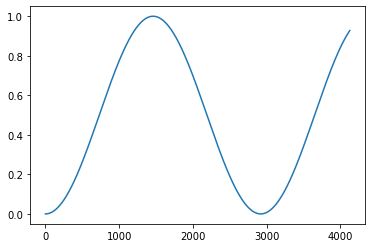

In [15]:
import math as m

time = []

for t in range(4128):
    time.append(m.sin(m.pi*t/2920)**2)
    
plt.plot(time)
plt.show()

In [16]:
time_arr = np.zeros((4128,96,96),dtype='float32')
for t in range(time_arr.shape[0]):
    time_arr[t,:,:] = time[t]

time_arr.shape

(4128, 96, 96)

#### DEM

dem_ds = nc.Dataset('data/raw/DEM.nc')
dem_ds

DEM = np.array(dem_ds['Band1'])
DEM.shape

lon_DEM = dem_ds['lon']
lat_DEM = dem_ds['lat']

if(len(lat_DEM.shape)==1):
    lon_DEM, lat_DEM = np.meshgrid(lon_DEM, lat_DEM)

lon_DEM.shape

### Interpolating to same extent

This is done by changing longitude and latitude coordinates of the datasets to a cartesian grid and using nearest neighbor interpolation to get all data on the same grid (WRF 3km).

In [17]:
# target cartesian coordinates
xt, yt, zt = hf.lon_lat_to_cartesian(lon_WRF_3km_part1.flatten(), lat_WRF_3km_part1.flatten())

#### WRF 9 km

In [18]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_WRF_9km_part1.flatten(), lat_WRF_9km_part1.flatten())

tree = hf.cKDTree(np.column_stack((xs, ys, zs)))

In [19]:
# nearest neighbor
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

T_WRF_9km_part1_near = hf.transform_extent(T_WRF_9km_part1, inds, lat_WRF_3km_part1.shape)
U_WRF_9km_part1_near = hf.transform_extent(U_WRF_9km_part1, inds, lat_WRF_3km_part1.shape)
V_WRF_9km_part1_near = hf.transform_extent(V_WRF_9km_part1, inds, lat_WRF_3km_part1.shape)

In [20]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_WRF_9km_part2.flatten(), lat_WRF_9km_part2.flatten())

tree = hf.cKDTree(np.column_stack((xs, ys, zs)))

In [21]:
# nearest neighbor
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

T_WRF_9km_part2_near = hf.transform_extent(T_WRF_9km_part2, inds, lat_WRF_3km_part1.shape)
U_WRF_9km_part2_near = hf.transform_extent(U_WRF_9km_part2, inds, lat_WRF_3km_part1.shape)
V_WRF_9km_part2_near = hf.transform_extent(V_WRF_9km_part2, inds, lat_WRF_3km_part1.shape)

Concatenating the two 9km WRF datasets to 1

In [22]:
T_WRF_9km = np.concatenate((T_WRF_9km_part1_near, T_WRF_9km_part2_near))
U_WRF_9km = np.concatenate((U_WRF_9km_part1_near, U_WRF_9km_part2_near))
V_WRF_9km = np.concatenate((V_WRF_9km_part1_near, V_WRF_9km_part2_near))

print(T_WRF_9km.shape)

(4128, 96, 96)


Test data 9 km

In [23]:
T_WRF_9km_test = hf.transform_extent(T_WRF_9km_test_raw, inds, lat_WRF_3km_part1.shape)
U_WRF_9km_test = hf.transform_extent(U_WRF_9km_test_raw, inds, lat_WRF_3km_part1.shape)
V_WRF_9km_test = hf.transform_extent(V_WRF_9km_test_raw, inds, lat_WRF_3km_part1.shape)

T_WRF_9km_test.shape

(2920, 96, 96)

#### WRF 3km

In [24]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_WRF_3km_part2.flatten(), lat_WRF_3km_part2.flatten())

tree = hf.cKDTree(np.column_stack((xs, ys, zs)))

In [25]:
# nearest neighbor
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

T_WRF_3km_part2_near = hf.transform_extent(T_WRF_3km_part2, inds, lat_WRF_3km_part1.shape)
U_WRF_3km_part2_near = hf.transform_extent(U_WRF_3km_part2, inds, lat_WRF_3km_part1.shape)
V_WRF_3km_part2_near = hf.transform_extent(V_WRF_3km_part2, inds, lat_WRF_3km_part1.shape)

Concatenating the two 3km WRF datasets to 1

In [26]:
T_WRF_3km = np.concatenate((T_WRF_3km_part1, T_WRF_3km_part2_near))
U_WRF_3km = np.concatenate((U_WRF_3km_part1, U_WRF_3km_part2_near))
V_WRF_3km = np.concatenate((V_WRF_3km_part1, V_WRF_3km_part2_near))

Test data 3km

In [27]:
T_WRF_3km_test = hf.transform_extent(T_WRF_3km_test_raw, inds, lat_WRF_3km_part1.shape)
U_WRF_3km_test = hf.transform_extent(U_WRF_3km_test_raw, inds, lat_WRF_3km_part1.shape)
V_WRF_3km_test = hf.transform_extent(V_WRF_3km_test_raw, inds, lat_WRF_3km_part1.shape)

T_WRF_3km_test.shape

(2920, 96, 96)

#### NCEP

In [28]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_NCEP.flatten(), lat_NCEP.flatten())

tree = hf.cKDTree(np.column_stack((xs, ys, zs)))

In [29]:
# nearest neighbour
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

T_NCEP_near = hf.transform_extent(T_NCEP, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km.shape[0]]
U_NCEP_near = hf.transform_extent(U_NCEP, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km.shape[0]]
V_NCEP_near = hf.transform_extent(V_NCEP, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km.shape[0]]


NCEP test

In [30]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_NCEP_test.flatten(), lat_NCEP_test.flatten())

tree = hf.cKDTree(np.column_stack((xs, ys, zs)))

In [31]:
# nearest neighbour
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

T_NCEP_test_near = hf.transform_extent(T_NCEP_test, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km_test.shape[0]]
U_NCEP_test_near = hf.transform_extent(U_NCEP_test, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km_test.shape[0]]
V_NCEP_test_near = hf.transform_extent(V_NCEP_test, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km_test.shape[0]]

In [32]:
T_NCEP_test_near.shape

(2920, 96, 96)

#### DEM

xs, ys, zs = hf.lon_lat_to_cartesian(lon_DEM.flatten(), lat_DEM.flatten())

tree = cKDTree(np.column_stack((xs, ys, zs)))

# nearest neighbour
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

DEM_near = hf.transform_extent(DEM, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km.shape[0]]
DEM_near.shape

DEM_norm = hf.minmax_norm(DEM_near)
np.max(DEM_norm)

#### Deleting raw datasets to save RAM space

In [33]:
del c1
del c2
del c3
del c4

In [34]:
del ds1, ds2, ds3, ds4#, ds5, ds6

In [35]:
del T_WRF_9km_part1, T_WRF_9km_part2
del U_WRF_9km_part1, U_WRF_9km_part2
del V_WRF_9km_part1, V_WRF_9km_part2

In [36]:
del T_WRF_3km_part1, T_WRF_3km_part2
del U_WRF_3km_part1, U_WRF_3km_part2
del V_WRF_3km_part1, V_WRF_3km_part2

In [37]:
del xs, xt, ys, yt, zs, zt
del d, inds

### Downscaling

Current model is doing downscaling by increasing the pixel count, so it wants a low pixel count image and increase the pixel count by an integer factor. For us the low resolution to medium resolution is 16x16 pixels to 32x32. And medium to high resolution is 32x32 to 96x96. 

In [38]:
# Training data 
T_WRF_9km_down = hf.downscale_image(T_WRF_9km, 3)
U_WRF_9km_down = hf.downscale_image(U_WRF_9km, 3)
V_WRF_9km_down = hf.downscale_image(V_WRF_9km, 3)

T_NCEP_down = hf.downscale_image(T_NCEP_near, 6)
U_NCEP_down = hf.downscale_image(U_NCEP_near, 6)
V_NCEP_down = hf.downscale_image(V_NCEP_near, 6)


# Test data 
T_NCEP_test_down = hf.downscale_image(T_NCEP_test_near, 6)
U_NCEP_test_down = hf.downscale_image(U_NCEP_test_near, 6)
V_NCEP_test_down = hf.downscale_image(V_NCEP_test_near, 6)

T_WRF_9km_down.shape, T_NCEP_down.shape, T_NCEP_test_down.shape

((4128, 32, 32, 1), (4128, 16, 16, 1), (2920, 16, 16, 1))

### Writing data to .npy for analysis

We should save the data to numpy arrays so we can read them later in analysis scripts.

In [39]:
# TRAIN

# WRF 3km
np.save('Analysis/T_WRF_3km.npy', T_WRF_3km)
np.save('Analysis/U_WRF_3km.npy', U_WRF_3km)
np.save('Analysis/V_WRF_3km.npy', V_WRF_3km)

# WRF 9km
np.save('Analysis/T_WRF_9km.npy', T_WRF_9km)
np.save('Analysis/U_WRF_9km.npy', U_WRF_9km)
np.save('Analysis/V_WRF_9km.npy', V_WRF_9km)

# NCEP native
np.save('Analysis/T_NCEP_near.npy', T_NCEP_near)
np.save('Analysis/U_NCEP_near.npy', U_NCEP_near)
np.save('Analysis/V_NCEP_near.npy', V_NCEP_near)

# NCEP down
np.save('Analysis/T_NCEP_down.npy', T_NCEP_down)
np.save('Analysis/U_NCEP_down.npy', U_NCEP_down)
np.save('Analysis/V_NCEP_down.npy', V_NCEP_down)



In [40]:
# TEST

# WRF 3km
np.save('Analysis/T_WRF_3km_test.npy', T_WRF_3km_test)
np.save('Analysis/U_WRF_3km_test.npy', U_WRF_3km_test)
np.save('Analysis/V_WRF_3km_test.npy', V_WRF_3km_test)

# WRF 9km
np.save('Analysis/T_WRF_9km_test.npy', T_WRF_9km_test)
np.save('Analysis/U_WRF_9km_test.npy', U_WRF_9km_test)
np.save('Analysis/V_WRF_9km_test.npy', V_WRF_9km_test)

# NCEP

# NCEP down
np.save('Analysis/T_NCEP_test_down.npy', T_NCEP_test_down)
np.save('Analysis/U_NCEP_test_down.npy', U_NCEP_test_down)
np.save('Analysis/V_NCEP_test_down.npy', V_NCEP_test_down)